In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import os
import seaborn as sns
from scipy import stats

from my_settings import one_hot, log_transform_config, use_regression, plotting

print("one_hot:", one_hot)
print("log_transform_config:", log_transform_config)
print("use_regression:", use_regression)
print("plotting:", plotting)

"""
original_mgfe = df['MgFe'].copy()
if one_hot:
    bins = [0.0, 0.1, 0.2, 0.3, 0.4, np.inf]
    mgfe_labels = ['MgFe_0.0', 'MgFe_0.1', 'MgFe_0.2', 'MgFe_0.3', 'MgFe_0.4']
    df['MgFe_binned'] = pd.cut(df['MgFe'], bins=bins, labels=mgfe_labels, include_lowest=True, right=False)
    df = df.drop(columns=['MgFe'])
    
    # Perform one-hot encoding on the binned MgFe column
    df_encoded = pd.get_dummies(df['MgFe_binned'], prefix='', prefix_sep='')
    df = pd.concat([df, df_encoded], axis=1)
    
    selected_features = [col for col in df.columns if col in selected_features or col in mgfe_labels]

# Remove one-hot encoding and restore original MgFe
if one_hot:
    one_hot_columns = [col for col in df.columns if col in mgfe_labels]
    df = df.drop(columns=one_hot_columns + ['MgFe_binned'])  # Remove one-hot columns and binned column
    df['MgFe'] = original_mgfe  # Restore original MgFe values
    
    # Update selected_features to remove one-hot columns and add back MgFe
    selected_features = [col for col in selected_features if col not in mgfe_labels]
    selected_features.append('MgFe')

"""

def prepare_data(data, selected_features, log_transform_features):
    
    data = data.copy()

    for feature, do_log in log_transform_features.items():
        if do_log and feature in data.columns:
            data[feature] = np.log10(data[feature] + 1e-10)
            
    if isinstance(data, pd.DataFrame):
        if isinstance(selected_features[0], str):
            X = data[selected_features].values
            feature_names = selected_features
        else:
            X = data.iloc[:, selected_features].values
            feature_names = data.columns[selected_features].tolist()
    else:
        X = data[:, selected_features]
        feature_names = [f"Feature {i}" for i in selected_features]
    
    return X, feature_names

def make_corner_plot(data, labels, plot_features, method_name, figsize=(12, 12)):
    n_features = len(plot_features)
    fig, axes = plt.subplots(n_features, n_features, figsize=figsize)
    
    # Ensure labels are integer type
    labels = np.asarray(labels, dtype=int)
    
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    padding = 0.1
    
    for i in range(n_features):
        for j in range(n_features):
            ax = axes[i, j]
            
            if i < j:  # Upper triangle
                ax.set_visible(False)
                continue
                
            xmin = min(data[plot_features[j]]) - padding
            xmax = max(data[plot_features[j]]) + padding
            ymin = min(data[plot_features[i]]) - padding
            ymax = max(data[plot_features[i]]) + padding
                
            if i == j:  # Diagonal
                for label, color in zip(unique_labels, colors):
                    mask = (labels == label)
                    ax.hist(data.loc[mask, plot_features[i]], bins=20, 
                           color=color, alpha=0.6, label=f'Cluster {label}')
                ax.set_xlim(xmin, xmax)
                ax.set_title(plot_features[i])
            else:  # Lower triangle
                for label, color in zip(unique_labels, colors):
                    mask = (labels == label)
                    ax.scatter(data.loc[mask, plot_features[j]], 
                             data.loc[mask, plot_features[i]],
                             c=[color], alpha=0.6, s=20, label=f'Cluster {label}')
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)
            
            # Labels
            if i == n_features-1:
                ax.set_xlabel(plot_features[j])
            if j == 0:
                ax.set_ylabel(plot_features[i])
                
            # Only show legend once in the first subplot
            if i == n_features-1 and j == 0:
                ax.legend(title="Clusters", bbox_to_anchor=(0.5, 0.5))

    plt.tight_layout()
    return fig

def plot_multi_method_features(data, methods, features, figsize=(15, 10)):
    n_methods = len(methods)
    n_features = len(features)
    
    fig, axes = plt.subplots(n_methods, n_features, figsize=figsize)
    if n_methods == 1:
        axes = axes.reshape(1, -1)
    
    # Get colors for clusters
    max_clusters = max(len(np.unique(labels)) for labels in methods.values())
    colors = plt.cm.rainbow(np.linspace(0, 1, max_clusters))
    
    for row, (method_name, labels) in enumerate(methods.items()):
        unique_labels = np.unique(labels)
        
        for col, feature in enumerate(features):
            ax = axes[row, col]
            
            # Plot scatter for each cluster
            for label, color in zip(unique_labels, colors):
                mask = labels == label
                ax.scatter(data['DoR'][mask], data[feature][mask],
                          c=[color], alpha=0.6, label=f'Cluster {label}')
            
            ax.set_xlabel('DoR')
            ax.set_ylabel(feature)
            
            if col == 0:
                ax.set_title(f'{method_name}\n{feature} vs DoR')
            else:
                ax.set_title(f'{feature} vs DoR')            
            if row == 0 and col == 0:
                ax.legend(title="Clusters")
                
    plt.tight_layout()
    return fig

def relabel_by_dor_and_mgfe(labels, df):
        # Calculate mean metrics for each cluster
        cluster_stats = {}
        for label in np.unique(labels):
            mask = labels == label
            cluster_stats[label] = {
                'DoR': df[mask]['DoR'].mean(),
                'MgFe': df[mask]['MgFe'].mean(),
                'size': mask.sum()
            }
            print(f"\nOriginal Cluster {label}:")
            print(f"Mean DoR: {cluster_stats[label]['DoR']:.3f}")
            #print(f"Mean MgFe: {cluster_stats[label]['MgFe']:.3f}")
            print(f"Size: {cluster_stats[label]['size']}")
        # After sorting but before creating mapping
        sorted_keys = sorted(cluster_stats.keys(), key=lambda x: cluster_stats[x]['DoR'], reverse=True)
        print("Sorted keys:", sorted_keys)
        print("Their DoR values:", [cluster_stats[k]['DoR'] for k in sorted_keys])
        # Create mapping using both DoR and MgFe
        mapping = dict(enumerate(sorted(cluster_stats.keys(),
                                     key=lambda x: cluster_stats[x]['DoR'],
                                     reverse=True)))
        
        print("\nCluster Mapping:")
        for new_label, old_label in mapping.items():
            print(f"Old cluster {old_label} → New cluster {new_label}")
        
        return np.array([mapping[label] for label in labels])



def export_clustering_results(df, methods,approach_name, output_path='../data/cluster_results'):
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    # Create SDSS identifiers
    sdss_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])]
    
    # Export results with relabeled clusters
    for method_name, labels in methods.items():
        print(f"\nRelabeling {method_name} clusters:")
        relabeled_labels = relabel_by_dor_and_mgfe(labels, df)
        results_df = pd.DataFrame({
            'SDSS_ID': sdss_ids,
            'Cluster': relabeled_labels
        })
        
        filename = os.path.join(output_path, f'{approach_name}_{method_name.lower().replace(" ", "_")}_clusters.csv')
        results_df.to_csv(filename, index=False)
        print("Made files")

def plot_dendrogram(data, selected_features, method='ward', figsize=(10,7)):

    # Prepare and scale data
    X, feature_names = prepare_data(data, selected_features, log_transform_features=log_transform_config)
    X_scaled = StandardScaler().fit_transform(X)
    
    # Calculate linkage matrix
    Z = linkage(X_scaled, method=method)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(Z)
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()
    
    return Z


one_hot: False
log_transform_config: {'age_mean_mass': False, 'velDisp_ppxf_res': True, 'MgFe': False, '[M/H]_mean_mass': False}
use_regression: True
plotting: False



# USAGE!!


In [21]:
selected_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass'] #, 'logM*','meanRadkpc_r', 'Mtbb3', 't_75', 't_100']

df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
df = df.sample(frac=1).reset_index(drop=True)
dor_values = df['DoR'].values  # Get DoR separately for coloring

In [22]:
def generate_weight_combinations(min_weight=0.05, max_weight=0.75, steps=20):
    weights = np.linspace(min_weight, max_weight, steps)
    valid_combinations = []
    
    for w1 in weights:
        for w2 in weights:
            for w3 in weights:
                w4 = 1 - (w1 + w2 + w3)
                if min_weight <= w4 <= max_weight:
                    valid_combinations.append([w1, w2, w3, w4])
    
    return np.array(valid_combinations)

def do_clustering(df, selected_features, feature_weights=None):
    X, feature_names = prepare_data(df, selected_features, log_transform_features=log_transform_config)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    
    if feature_weights is not None:
        weights = np.ones(len(feature_names))
        for feature, weight in feature_weights.items():
            if feature in feature_names:
                idx = feature_names.index(feature)
                weights[idx] = weight
        X_scaled = X_scaled * weights.reshape(1, -1)
    
    # K-means clustering
    n_clusters_kmeans = 3
    kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, init='k-means++', n_init=100)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    # GMM clustering
    n_clusters_gmm = 3
    cv_type = 'full' # covariance_types = ['full', 'tied', 'diag', 'spherical']
    
    gmm = GaussianMixture(
        n_components=n_clusters_gmm,
        covariance_type=cv_type,
        random_state=42,
        n_init=100,
        max_iter=300,
        reg_covar=1e-6,
        init_params='kmeans'
    )
    gmm_labels = gmm.fit_predict(X_scaled)
    
    # Hierarchical clustering
    n_clusters_hier = 3
    hc = AgglomerativeClustering(n_clusters=n_clusters_hier)
    hc_labels = hc.fit_predict(X_scaled)
    
    #plot_clusters(X, kmeans_labels, feature_names, "K-Means Clustering")
    #plt.show()
    
    methods = {
       "K-Means": kmeans_labels,
       "GMM": gmm_labels,
       "Hierarchical": hc_labels,   
    }
    
    return methods

def run_all_approaches(df, selected_features, steps = 20):

    print("\nRunning unweighted clustering...")
    unweighted_methods = do_clustering(df, selected_features, feature_weights=None)

    print("\nRunning regression-weighted clustering...")
    regression_methods = pd.read_csv('../data/regression_results/RandomForest_avg.csv')[['Feature', 'Mean_Importance']].to_dict(orient='records')
    regression_methods = {item['Feature']: item['Mean_Importance'] for item in regression_methods}
    print(regression_methods)
    regression_methods = do_clustering(df, selected_features, feature_weights=regression_methods)
    
    # 3. Grid search
    print("\nRunning grid search...")
    best_score = -np.inf
    best_weights = None
    best_methods = None
    
    # Prepare data once for scoring
    X, feature_names = prepare_data(df, selected_features, log_transform_features=log_transform_config)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    counter = 0
    total = steps**len(feature_names)
    for weights in generate_weight_combinations(min_weight=0.05, max_weight=0.75, steps=steps): # change for fineness of the grid
        counter += 1
        if counter %100 == 0:
            print("Count:",counter, " out of ",total)
        feature_weights = dict(zip(selected_features, weights))
        methods = do_clustering(df, selected_features, feature_weights)
        
        # Calculate average silhouette score across all methods
        method_scores = []
        for method_name, labels in methods.items():
            score = silhouette_score(X_scaled, labels)
            method_scores.append(score)
        
        avg_score = np.mean(method_scores)
        if avg_score > best_score:
            best_score = avg_score
            best_weights = weights
            best_methods = methods
            print(f"New best score: {best_score:.3f} with weights:", 
                  {f: w for f, w in zip(selected_features, weights)})

    return {
        'unweighted': unweighted_methods,
        'regression': regression_methods,
        'grid_search': best_methods,
        'best_weights': dict(zip(selected_features, best_weights))
    }

In [23]:
steps = 3
results = run_all_approaches(df, selected_features, steps)


Running unweighted clustering...

Running regression-weighted clustering...
{'age_mean_mass': 0.6088820229863239, '[M/H]_mean_mass': 0.2854979381495471, 'velDisp_ppxf_res': 0.0783056693873356, 'MgFe': 0.0273143694767933}

Running grid search...
New best score: 0.254 with weights: {'MgFe': 0.05, '[M/H]_mean_mass': 0.05, 'velDisp_ppxf_res': 0.39999999999999997, 'age_mean_mass': 0.5}


In [24]:
# Create plots for each approach
for approach_name, methods in results.items():
    if approach_name != 'best_weights':  # Skip the weights dictionary
        
        # Corner plots for each method within this approach
        for method_name, labels in methods.items():
            print(f"\nAPPROACH: {approach_name}")
            print(f"method: {method_name}")
            if plotting:
                fig = make_corner_plot(df, labels, selected_features, f"{approach_name}-{method_name}")
                plt.show()
        
        # Multi-method feature plots for this approach
        if plotting:
            print("METHODS -> features vs DoR ")
            fig = plot_multi_method_features(df, methods, selected_features, figsize=(12, 12))
            plt.show()

print("\nBest weights from grid search:")
for feature, weight in results['best_weights'].items():
    print(f"{feature}: {weight:.3f}")


APPROACH: unweighted
method: K-Means

APPROACH: unweighted
method: GMM

APPROACH: unweighted
method: Hierarchical

APPROACH: regression
method: K-Means

APPROACH: regression
method: GMM

APPROACH: regression
method: Hierarchical

APPROACH: grid_search
method: K-Means

APPROACH: grid_search
method: GMM

APPROACH: grid_search
method: Hierarchical

Best weights from grid search:
MgFe: 0.050
[M/H]_mean_mass: 0.050
velDisp_ppxf_res: 0.400
age_mean_mass: 0.500


In [25]:
for approach_name, methods in results.items():
    print(f"APPROACH: {approach_name}")
    if approach_name != 'best_weights':  # Skip the weights dictionary
        export_clustering_results(df, methods, approach_name)
    else:
        print("Best weights - no exporting")

APPROACH: unweighted

Relabeling K-Means clusters:

Original Cluster 0:
Mean DoR: 0.572
Size: 167

Original Cluster 1:
Mean DoR: 0.514
Size: 175

Original Cluster 2:
Mean DoR: 0.299
Size: 88
Sorted keys: [0, 1, 2]
Their DoR values: [0.5721913194011977, 0.5136677810857142, 0.2991993763977273]

Cluster Mapping:
Old cluster 0 → New cluster 0
Old cluster 1 → New cluster 1
Old cluster 2 → New cluster 2
Made files

Relabeling GMM clusters:

Original Cluster 0:
Mean DoR: 0.379
Size: 32

Original Cluster 1:
Mean DoR: 0.592
Size: 210

Original Cluster 2:
Mean DoR: 0.401
Size: 188
Sorted keys: [1, 2, 0]
Their DoR values: [0.5917115317333334, 0.40107740817553195, 0.37860571099999996]

Cluster Mapping:
Old cluster 1 → New cluster 0
Old cluster 2 → New cluster 1
Old cluster 0 → New cluster 2
Made files

Relabeling Hierarchical clusters:

Original Cluster 0:
Mean DoR: 0.526
Size: 155

Original Cluster 1:
Mean DoR: 0.291
Size: 81

Original Cluster 2:
Mean DoR: 0.549
Size: 194
Sorted keys: [2, 0, 1]
T

In [26]:
# Create DoR clustering as well for reference. 

dor_labels = np.zeros(len(df), dtype=int)  # Specify dtype=int here
dor_labels[(df['DoR'] >= 0.3) & (df['DoR'] < 0.6)] = 1
dor_labels[df['DoR'] >= 0.6] = 2

print("\nDoR Group sizes and means:")
for i, name in enumerate(['DoR < 0.3', '0.3 ≤ DoR < 0.6', 'DoR ≥ 0.6']):
    mask = dor_labels == i
    print(f"{name}: {np.sum(mask)} galaxies, mean DoR = {df['DoR'][mask].mean():.3f}")

# Create methods dictionary with the integer labels
dor_methods = {
    "DoR": dor_labels.astype(int)  # Ensure integer type
}

if plotting:
    fig = make_corner_plot(df, dor_labels, selected_features, 'DoR Groups')
    plt.show()
    
    features = selected_features #['velDisp_ppxf_res', '[M/H]_mean_mass']
    fig = plot_multi_method_features(df, dor_methods, features, figsize=(12, 12))
    plt.show()

name = 'DoR_3_6'
export_clustering_results(df, dor_methods, name)


DoR Group sizes and means:
DoR < 0.3: 56 galaxies, mean DoR = 0.229
0.3 ≤ DoR < 0.6: 293 galaxies, mean DoR = 0.486
DoR ≥ 0.6: 81 galaxies, mean DoR = 0.699

Relabeling DoR clusters:

Original Cluster 0:
Mean DoR: 0.229
Size: 56

Original Cluster 1:
Mean DoR: 0.486
Size: 293

Original Cluster 2:
Mean DoR: 0.699
Size: 81
Sorted keys: [2, 1, 0]
Their DoR values: [0.6992634421851851, 0.4858012504982935, 0.22852235607142854]

Cluster Mapping:
Old cluster 2 → New cluster 0
Old cluster 1 → New cluster 1
Old cluster 0 → New cluster 2
Made files


Some analysis of tranformation effects and distributions of parameters


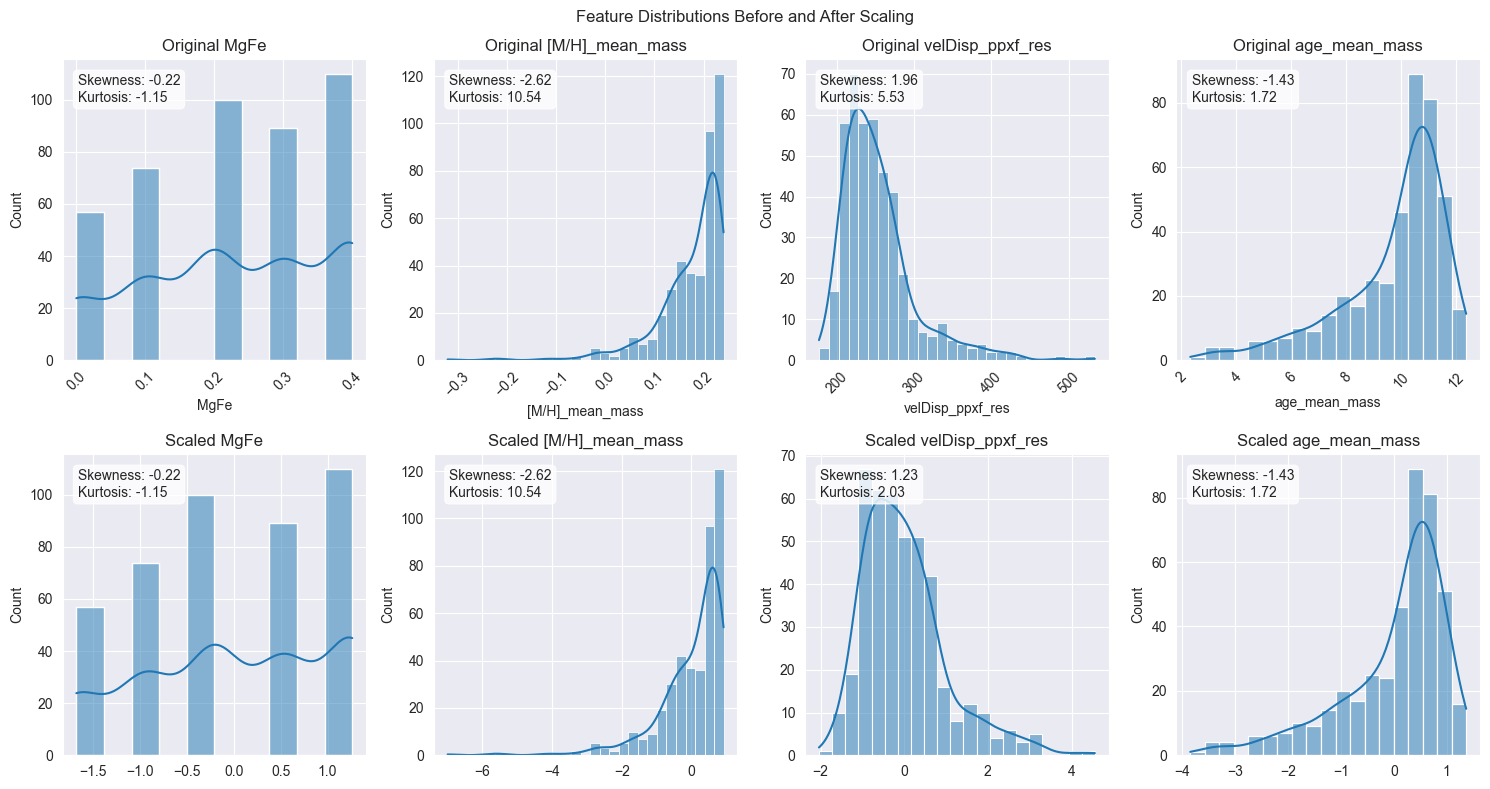

In [27]:
def analyze_distributions(data, selected_features):
    n_features = len(selected_features)
    fig, axes = plt.subplots(2, n_features, figsize=(15, 8))
    fig.suptitle('Feature Distributions Before and After Scaling')

    X, feature_names = prepare_data(data, selected_features, log_transform_features=log_transform_config)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Plot histograms and QQ plots for each feature
    for i, feature in enumerate(selected_features):
        # Original data
        sns.histplot(data[feature], kde=True, ax=axes[0, i])
        axes[0, i].set_title(f'Original {feature}')
        axes[0, i].tick_params(axis='x', rotation=45)

        # Add skewness and kurtosis
        skew = stats.skew(data[feature].dropna())
        kurt = stats.kurtosis(data[feature].dropna())
        axes[0, i].text(0.05, 0.95, f'Skewness: {skew:.2f}\nKurtosis: {kurt:.2f}',
                        transform=axes[0, i].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        sns.histplot(X_scaled[:, i], kde=True, ax=axes[1, i])
        axes[1, i].set_title(f'Scaled {feature}')

        skew_scaled = stats.skew(X_scaled[:, i])
        kurt_scaled = stats.kurtosis(X_scaled[:, i])
        axes[1, i].text(0.05, 0.95, f'Skewness: {skew_scaled:.2f}\nKurtosis: {kurt_scaled:.2f}',
                        transform=axes[1, i].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

fig = analyze_distributions(df, selected_features)
plt.show()

# print("\nDetailed Statistics:")
for feature in selected_features:
    #print(f"\n{feature}:")
    #print(df[feature].describe())

    stat, p_value = stats.normaltest(df[feature].dropna())
    #print(f"Normality test p-value: {p_value:.2e}")

    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    #print(f"IQR: {iqr:.2f}")
    #print(f"Outliers: {sum((df[feature] < (q1 - 1.5 * iqr)) | (df[feature] > (q3 + 1.5 * iqr)))} points")

In [28]:
# Make a copy to test transformations
df_test = df.copy()

def plot_transforms():
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Different Transformations of age_mean_mass')
    
    # Original
    sns.histplot(df_test['age_mean_mass'], kde=True, ax=axs[0,0])
    axs[0,0].set_title(f'Original\nSkewness: {stats.skew(df_test["age_mean_mass"]):.2f}')
    
    # Log (what you tried)
    sns.histplot(np.log10(df_test['age_mean_mass']), kde=True, ax=axs[0,1])
    axs[0,1].set_title(f'Log10\nSkewness: {stats.skew(np.log10(df_test["age_mean_mass"])):.2f}')
    
    # Exponential (what you suggested)
    sns.histplot(np.exp(df_test['age_mean_mass']), kde=True, ax=axs[0,2])
    axs[0,2].set_title(f'Exp\nSkewness: {stats.skew(np.exp(df_test["age_mean_mass"])):.2f}')
    
    # Square root (often good for left-skewed data)
    sns.histplot(np.sqrt(df_test['age_mean_mass']), kde=True, ax=axs[1,0])
    axs[1,0].set_title(f'Square Root\nSkewness: {stats.skew(np.sqrt(df_test["age_mean_mass"])):.2f}')
    
    # Square (another option)
    sns.histplot(df_test['age_mean_mass']**2, kde=True, ax=axs[1,1])
    axs[1,1].set_title(f'Square\nSkewness: {stats.skew(df_test["age_mean_mass"]**2):.2f}')
    
    plt.tight_layout()
    plt.show()
    
# plot_transforms()